In [1]:
!pip install higra

     |████████████████████████████████| 9.8MB 3.9MB/s 


In [2]:
import numpy as np
import torch as tc
import higra as hg
import imageio

import math
from torch.nn import Module
from torch.autograd import Function
import matplotlib.pyplot as plt

try:
    from utils import * # imshow, locate_resource
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())

# Differentiable component trees

Component trees are based on the decomposition of the level sets of a vertex valued graph into connected components. Each connected component can be associated to an altitude which is equal to the level of the first level set where the component appears. The altitude of a component is thus equal to the value of some vertices of the graph. We can then back-propagate a modification of the tree altitudes to the original vertex values.   

The following functions implement component-trees (max-tree, min-tree, and tree-of-shapes) as Pytorch functions where the altitudes of the tree are differentiable with respect to the vertex values of the input graph.

In [3]:
class ComponentTreeFunction(Function):
  @staticmethod
  def forward(ctx, graph, vertex_weights, tree_type="max", plateau_derivative="full"):
    """
    Construct a component tree of the given vertex weighted graph.

    tree_type must be in ("min", "max", "tos")

    plateau_derivative can be "full" or "single". In the first case, the gradient of an altitude component
    is back-propagated to the vertex weights of the whole plateau (to all proper vertices of the component).
    In the second case, an arbitrary vertex of the plateau is selected and will receive the gradient.

    return: the altitudes of the tree (torch tensor), the tree itself is stored as an attribute of the tensor
    """
    if tree_type == "max":
      tree, altitudes = hg.component_tree_max_tree(graph, vertex_weights.detach().numpy())
    elif tree_type == "min":
      tree, altitudes = hg.component_tree_min_tree(graph, vertex_weights.detach().numpy())
    elif tree_type == "tos":
      tree, altitudes = hg.component_tree_tree_of_shapes_image2d(vertex_weights.detach().numpy())
    else:
      raise ValueError("Unknown tree type " + str(tree_type))

    if plateau_derivative == "full":
      plateau_derivative = True
    elif plateau_derivative == "single":
      plateau_derivative = False
    else:
      raise ValueError("Unknown plateau derivative type " + str(plateau_derivative))
    ctx.saved = (tree, graph, plateau_derivative)
    altitudes = tc.from_numpy(altitudes).clone().requires_grad_(True)
    # torch function can only return tensors, so we hide the tree as a an attribute of altitudes
    altitudes.tree = tree
    return altitudes

  @staticmethod
  def backward(ctx, grad_output):
    tree, graph, plateau_derivative = ctx.saved
    if plateau_derivative:
      grad_in = grad_output[tree.parents()[:tree.num_leaves()]]
    else:
      leaf_parents = tree.parents()[:tree.num_leaves()]
      _, indices = np.unique(leaf_parents, return_index=True)
      grad_in = tc.zeros((tree.num_leaves(),), dtype=grad_output.dtype)
      grad_in[indices] = grad_output[leaf_parents[indices]]
    return None, hg.delinearize_vertex_weights(grad_in, graph), None

class ComponentTree(Module):
    def __init__(self, tree_type):
        super().__init__()
        tree_types = ("max", "min", "tos")
        if tree_type not in tree_types:
          raise ValueError("Unknown tree type " + str(tree_type) + " possible values are " + " ".join(tree_types))

        self.tree_type = tree_type

    def forward(self, graph, vertex_weights):
        altitudes = ComponentTreeFunction.apply(graph, vertex_weights, self.tree_type)
        return altitudes.tree, altitudes

max_tree = ComponentTree("max")
min_tree = ComponentTree("min")
tos_tree = ComponentTree("tos")

# Definition of a utility Optimizer class 

This is a simple class to perform gradient descent based optimization with pytorch.

In [4]:
class Optimizer:
  def __init__(self, loss, lr, optimizer="adam"):
    """
    Create an Optimizer utility object

    loss: function that takes a single torch tensor which support requires_grad = True and returns a torch scalar
    lr: learning rate
    optimizer: "adam" or "sgd"
    """
    self.loss_function = loss
    self.history = []
    self.optimizer = optimizer
    self.lr = lr
    self.best = None
    self.best_loss = float("inf")

  def fit(self, data, iter=1000, debug=False, min_lr=1e-6):
    """
    Fit the given data

    data: torch tensor, input data
    iter: int, maximum number of iterations
    debug: int, if > 0, print current loss value and learning rate every debug iterations
    min_lr: float, minimum learning rate (an LR scheduler is used), if None, no LR scheduler is used 
    """
    data = data.clone().requires_grad_(True)
    if self.optimizer == "adam":
      optimizer = tc.optim.Adam([data], lr=self.lr, amsgrad=True)
    else:
      optimizer = tc.optim.SGD([data], lr=self.lr)

    if min_lr:
      lr_scheduler = tc.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=100)

    for t in range(iter):
      optimizer.zero_grad()
      loss = self.loss_function(tc.relu(data))
      loss.backward()
      optimizer.step()  
      loss_value = loss.item()
      
      self.history.append(loss_value) 
      if loss_value < self.best_loss:
        self.best_loss = loss_value
        self.best = tc.relu(data).clone()
        
      if min_lr:
        lr_scheduler.step(loss_value)
        if optimizer.param_groups[0]['lr'] <= min_lr:
          break

      if debug and t % debug == 0:
        print("Iteration {}: Loss: {:.4f}, LR: {}".format(t, loss_value, optimizer.param_groups[0]['lr']))
    return self.best

  def show_history(self):
    """
    Plot loss history
    """
    plt.plot(self.history)
    plt.show()


# Definition of test data

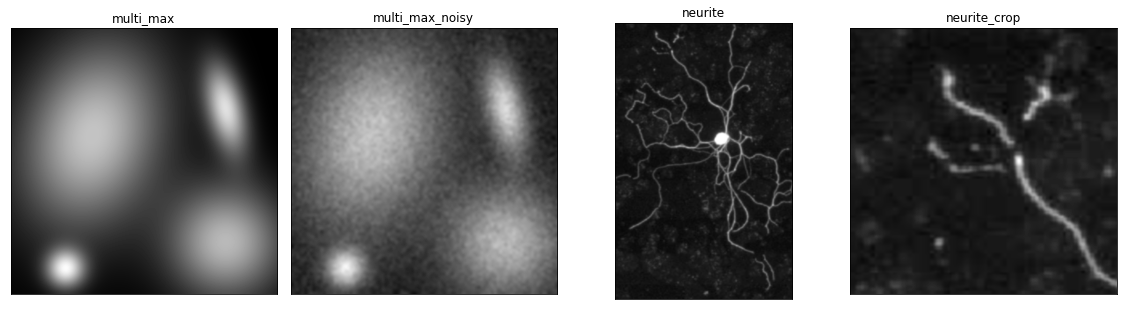

In [5]:
testimage = {}
np.random.seed(42)

def draw_Gaussian_2d(im, x0, y0, sigma_X, sigma_Y, theta, A):
  """
  Draw a 2d gaussian in the buffer image im at position (x0, y0), with 
  standard deviation sigma_X and sigma_Y, a rotation of theta, and a central
  brightness equal to A.
  """

  X, Y = np.meshgrid(np.arange(im.shape[0]), np.arange(im.shape[1]))

  a = np.cos(theta)**2/(2*sigma_X**2) + np.sin(theta)**2/(2*sigma_Y**2)
  b = -np.sin(2*theta)/(4*sigma_X**2) + np.sin(2*theta)/(4*sigma_Y**2)
  c = np.sin(theta)**2/(2*sigma_X**2) + np.cos(theta)**2/(2*sigma_Y**2)

  Z = A*np.exp( - (a*(X-x0)**2 + 2*b*(X-x0)*(Y-y0) + c*(Y-y0)**2))
  
  im += Z


def gen_multi_max(noise):
  """
  Create a test image with 4 maxima of various sizes and brightnesses
  """
  im = np.zeros((100, 100))
  draw_Gaussian_2d(im, 30, 40, 18, 25, -0.3, 1.7)
  draw_Gaussian_2d(im, 20, 90, 5, 5, 0, 2)
  draw_Gaussian_2d(im, 80, 30, 12, 5, 1.8, 1.9)
  draw_Gaussian_2d(im, 80, 80, 15, 15, 0, 1.6)

  im = im / im.max()
  if noise > 0:
    im = im + np.random.randn(*im.shape) * noise
    im = im / im.max()
  return im


testimage["multi_max"] = gen_multi_max(noise=0)
testimage["multi_max_noisy"] = gen_multi_max(noise=0.05)

testimage["neurite"] = imageio.imread("http://perso.esiee.fr/~perretb/neurite.png")[:,:,0]
testimage["neurite"] = 1 - testimage["neurite"]/testimage["neurite"].max()
testimage["neurite_crop"] = testimage["neurite"][0:150,50:200]


figsize = 4
fig = plt.figure(figsize=(figsize * figsize, len(testimage)))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
def plot_im(rows, columns, y, x, im, title):
    plt.subplot(rows, columns, y * columns + x + 1); 
    plt.imshow(im, interpolation="bicubic", cmap="gray"); 
    plt.xticks([]); plt.yticks([])
    plt.title(title)

testdata = {}
for i, (k, im) in enumerate(testimage.items()):
  testdata[k] = (hg.get_8_adjacency_implicit_graph(im.shape), im)
  plot_im(1, len(testimage), 0, i, im, k)

# Ranked selector loss

In the following, our objective is to define loss functions that can *select* a given number of components in a tree and *remove* others. Assume that we have a subset of $k$ components $\{H_i\}$ of a hierarchy and:

- a saliency measure $\mathbf{sm}\in \mathbb{R}^k$ such that, for a given component $H_i$, increasing the value of the measure $\mathbf{m}_i$ will *reinforce* $H_i$ and decreasing $\mathbf{m}_i$ will tend to remove $H_i$. 
- an importance measure $\mathbf{im}\in \mathbb{R}^k$  which provides a ranking of the components to identify the most important ones that should be reinforced and those which should disappear.
Then, the following loss function will try to select the $\ell$ most important components are remove the others:

$$J_r(\mathbf{sm}, \mathbf{im}; \ell)  = \sum_{i=1}^{i\leq \ell} \max(m - \mathbf{sm}_{\mathbf{r}_i}, 0)^p + \sum_{i=\ell + 1}^{i\leq k} \mathbf{sm}_{\mathbf{r}_i}^p  \textrm{ with } \mathbf{r} = \textrm{argsort}(\mathbf{im})$$

with $m$ a margin, ie. a positive real value, and $p$ a positive real value.

In [6]:
def loss_ranked_selection(saliency_measure, importance_measure, num_positives, margin, p=1):
  """
  Will try to increase the ranked_measure value of the num_positives first elements to the margin value and decrease the measure on the remaining elements

  :param saliency_measure: 1d torch tensor
  :param importance_measure: torch tensor (same shape as saliency_measure)
  :param num_positive: int >= 0
  :param p: float >= 0 
  :return: a torch scalar
  """
  sorted_indices = tc.argsort(importance_measure, descending=True)
  saliency_measure = saliency_measure[sorted_indices]

  if len(saliency_measure) <= num_positives:
    return tc.sum(tc.relu(margin - saliency_measure)**p)
  else:
    return tc.sum(tc.relu(margin - saliency_measure[:num_positives])**p) + tc.sum(saliency_measure[num_positives:]**p)

# Maxima loss based on extinction values

We first define to auxiliary function used in the computation of extinction values associated to the nodes of a hierarchy.

The main function is attribute_saddle_node, which for any increasing attribute value, identifies for each node n, the closest ancestor of n, called saddle node, which contains a descendent having an attribute value greater than the attribute value of any descendent of n. 

In [7]:
def attribute_depth(tree, altitudes):
  """
  Compute the depth of any node of the tree which is equal to the largest altitude 
  in the subtree rooted in the current node. 

  :param tree: input tree
  :param altitudes: np array (1d), altitudes of the input tree nodes
  :return: np array (1d), depth of the tree nodes
  """
  return hg.accumulate_sequential(tree, altitudes[:tree.num_leaves()], hg.Accumulators.max)

def attribute_saddle_nodes(tree, attribute):
  """
  Let n be a node and let an be an ancestor of n. The node an has a single child node that contains n denoted by ch(an -> n). 
  The saddle and base nodes associated to a node n for the given attribute values are respectively the closest ancestor an  
  of n and the node ch(an -> n) such that there exists a child c of an with attr(ch(an -> n)) < attr(c). 

  :param tree: input tree
  :param attribute: np array (1d), attribute of the input tree nodes
  :return: (np array, np array), saddle and base nodes of the input tree nodes for the given attribute
  """
  max_child_index = hg.accumulate_parallel(tree, attribute, hg.Accumulators.argmax)
  child_index = hg.attribute_child_number(tree)
  main_branch = child_index == max_child_index[tree.parents()]
  main_branch[:tree.num_leaves()] = True

  saddle_nodes = hg.propagate_sequential(tree, np.arange(tree.num_vertices())[tree.parents()], main_branch)
  base_nodes = hg.propagate_sequential(tree, np.arange(tree.num_vertices()), main_branch)
  return saddle_nodes, base_nodes

Finally, the following loss function will try to enforce the presence of a prescribed number of maxima in the given image based on the given saliency and importance maxima measures. 


In [8]:
def loss_maxima(graph, image, saliency_measure, importance_measure, num_target_maxima, margin=1, p=1):
  """
  Loss that favors the presence of num_target_maxima in the given image. 

  
  :param graph: adjacency pixel graph
  :param image: torch tensor 1d, vertex values of the input graph
  :param saliency_measure: string, how the saliency of maxima is measured, can be "altitude" or "dynamics"
  :param importance_measure: string, how the importance of maxima is measured, can be "altitude", "dynamics", "area", or "volume"
  :param num_target_maxima: int >=0, number of maxima that should be present in the result
  :param margin: float >=0, target altitude fo preserved maxima
  :param p: float >=0, power (see parameter p in loss_ranked_selection)
  :return: a torch scalar
  """
  if not saliency_measure in ["altitude", "dynamics"]:
    raise ValueError("Saliency_measure can be either 'altitude' or 'dynamics'")

  if not importance_measure in ["altitude", "dynamics", "area", "volume"]:
    raise ValueError("Saliency_measure can be either 'altitude', 'dynamics', 'area', or 'volume'")
  
  tree, altitudes = max_tree(graph, image)
  altitudes_np = altitudes.detach().numpy()

  extrema = hg.attribute_extrema(tree, altitudes_np)
  extrema_indices = np.arange(tree.num_vertices())[extrema]
  extrema_altitudes = altitudes[tc.from_numpy(extrema_indices)]

  if importance_measure == "dynamics" or saliency_measure == "dynamics":
    depth = attribute_depth(tree, altitudes_np)
    saddle_nodes = tc.from_numpy(attribute_saddle_nodes(tree, depth)[0])
    extrema_dynamics = extrema_altitudes - altitudes[saddle_nodes[extrema_indices]]

  if importance_measure == "area":
    area = hg.attribute_area(tree)
    pass_nodes, base_nodes = attribute_saddle_nodes(tree, area)
    extrema_area = tc.from_numpy(area[base_nodes[extrema_indices]])

  if importance_measure == "volume":
    volume = hg.attribute_volume(tree, altitudes_np)
    pass_nodes, base_nodes = attribute_saddle_nodes(tree, volume)
    extrema_volume = tc.from_numpy(volume[base_nodes[extrema_indices]])
  
  if saliency_measure == "altitude":
    saliency = extrema_altitudes
  elif saliency_measure == "dynamics":
    saliency = extrema_dynamics

  if importance_measure == "altitude":
    importance = extrema_altitudes
  elif importance_measure == "dynamics":
    importance = extrema_dynamics
  elif importance_measure == "area":
    importance = extrema_area
  elif importance_measure == "volume":
    importance = extrema_volume

  return loss_ranked_selection(saliency, importance, num_target_maxima, margin, p)

# Experiments

## Maxima loss on a simulated image

The following test demonstrate the effect of the previous loss function loss_maxima on the test image multi_max_noisy.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)


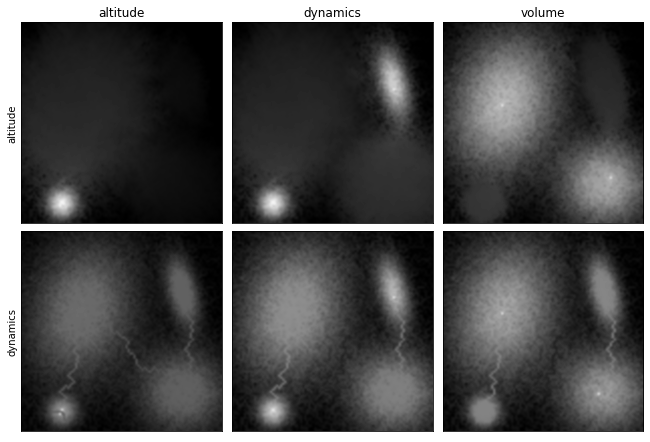

In [9]:
graph, image = testdata["multi_max_noisy"]

saliency_measures = ["altitude", "dynamics"]
importance_measures = ["altitude", "dynamics", "volume"]

fig = plt.figure(figsize=(3 * 3, 2 * 3))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

for i, sm in enumerate(saliency_measures):
  for j, im in enumerate(importance_measures):
    loss = lambda image: loss_maxima(graph, image, sm, im, num_target_maxima=2, margin=1, p=1)
    opt = Optimizer(loss, lr=0.001)
    opt.fit(tc.from_numpy(image.copy()), iter=3000, min_lr=None)

    # plotting
    res = opt.best.detach().numpy()
    f = plt.subplot(2, 3, i * 3 + j + 1); 
    plt.imshow(res, interpolation="bicubic", cmap="gray"); 
    plt.xticks([]); plt.yticks([])
    if j == 0:
      f.set_ylabel(sm)
    if i == 0:
      f.set_title(im)

## Neurite image filtering

The following example demosntrates how the loss function loss_maxima can be combined with a classical data fidelity term (L2 loss) and a classical regularization term (TV2 loss) to perform image filtering. 

The goal here is to reconstruct a neurite image $\mathbf{y}$ and we optimize the following loss function:

$$||\mathbf{f} - \mathbf{y}||_2^2 +  \lambda_1 J_{r}(\mathbf{dyn}(\mathbf{f}), \mathbf{dyn}(\mathbf{f}), 1) + \lambda_2 ||\nabla \mathbf{f}||_2^2
$$

Input image


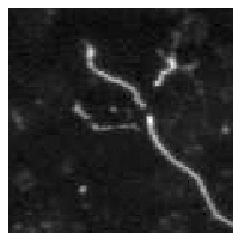

Filtered image


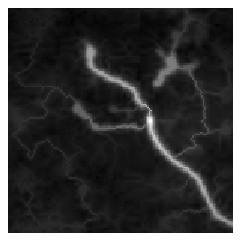

In [10]:
def loss_l2(image, observation):
  """
  l2 loss function: mean((image - observation)**2)
  """
  return tc.mean((image - observation)**2)

def loss_tv(image, p=2):
  """
  TV-p regularization: mean of the partial derivatives ** p
  """
  return tc.mean(tc.abs(image[:,1:] - image[:,:-1])**p) + tc.mean(tc.abs(image[1:,:] - image[:-1,:])**p)

graph, im = testdata["neurite_crop"]
im = im + np.random.rand(*im.shape) * 0.01
print("Input image")
imshow(im, cmap="gray")
im_tc = tc.from_numpy(im.copy())


def loss(image):
  l = (loss_l2(image, im_tc) + 
       0.05 * loss_maxima(graph, image, "dynamics", "dynamics", num_target_maxima=1, margin=0.5) + 
       0.5 * loss_tv(image, 2))
  return l

opt = Optimizer(loss, lr=0.001)
opt.fit(tc.from_numpy(im.copy()), iter=3000)
print("Filtered image")
imshow(opt.best.detach().numpy(), cmap="gray");